In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.utils.data.dataset import random_split
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Set image size
IMG_SIZE = 256

Image shape: (1958, 2588, 3)


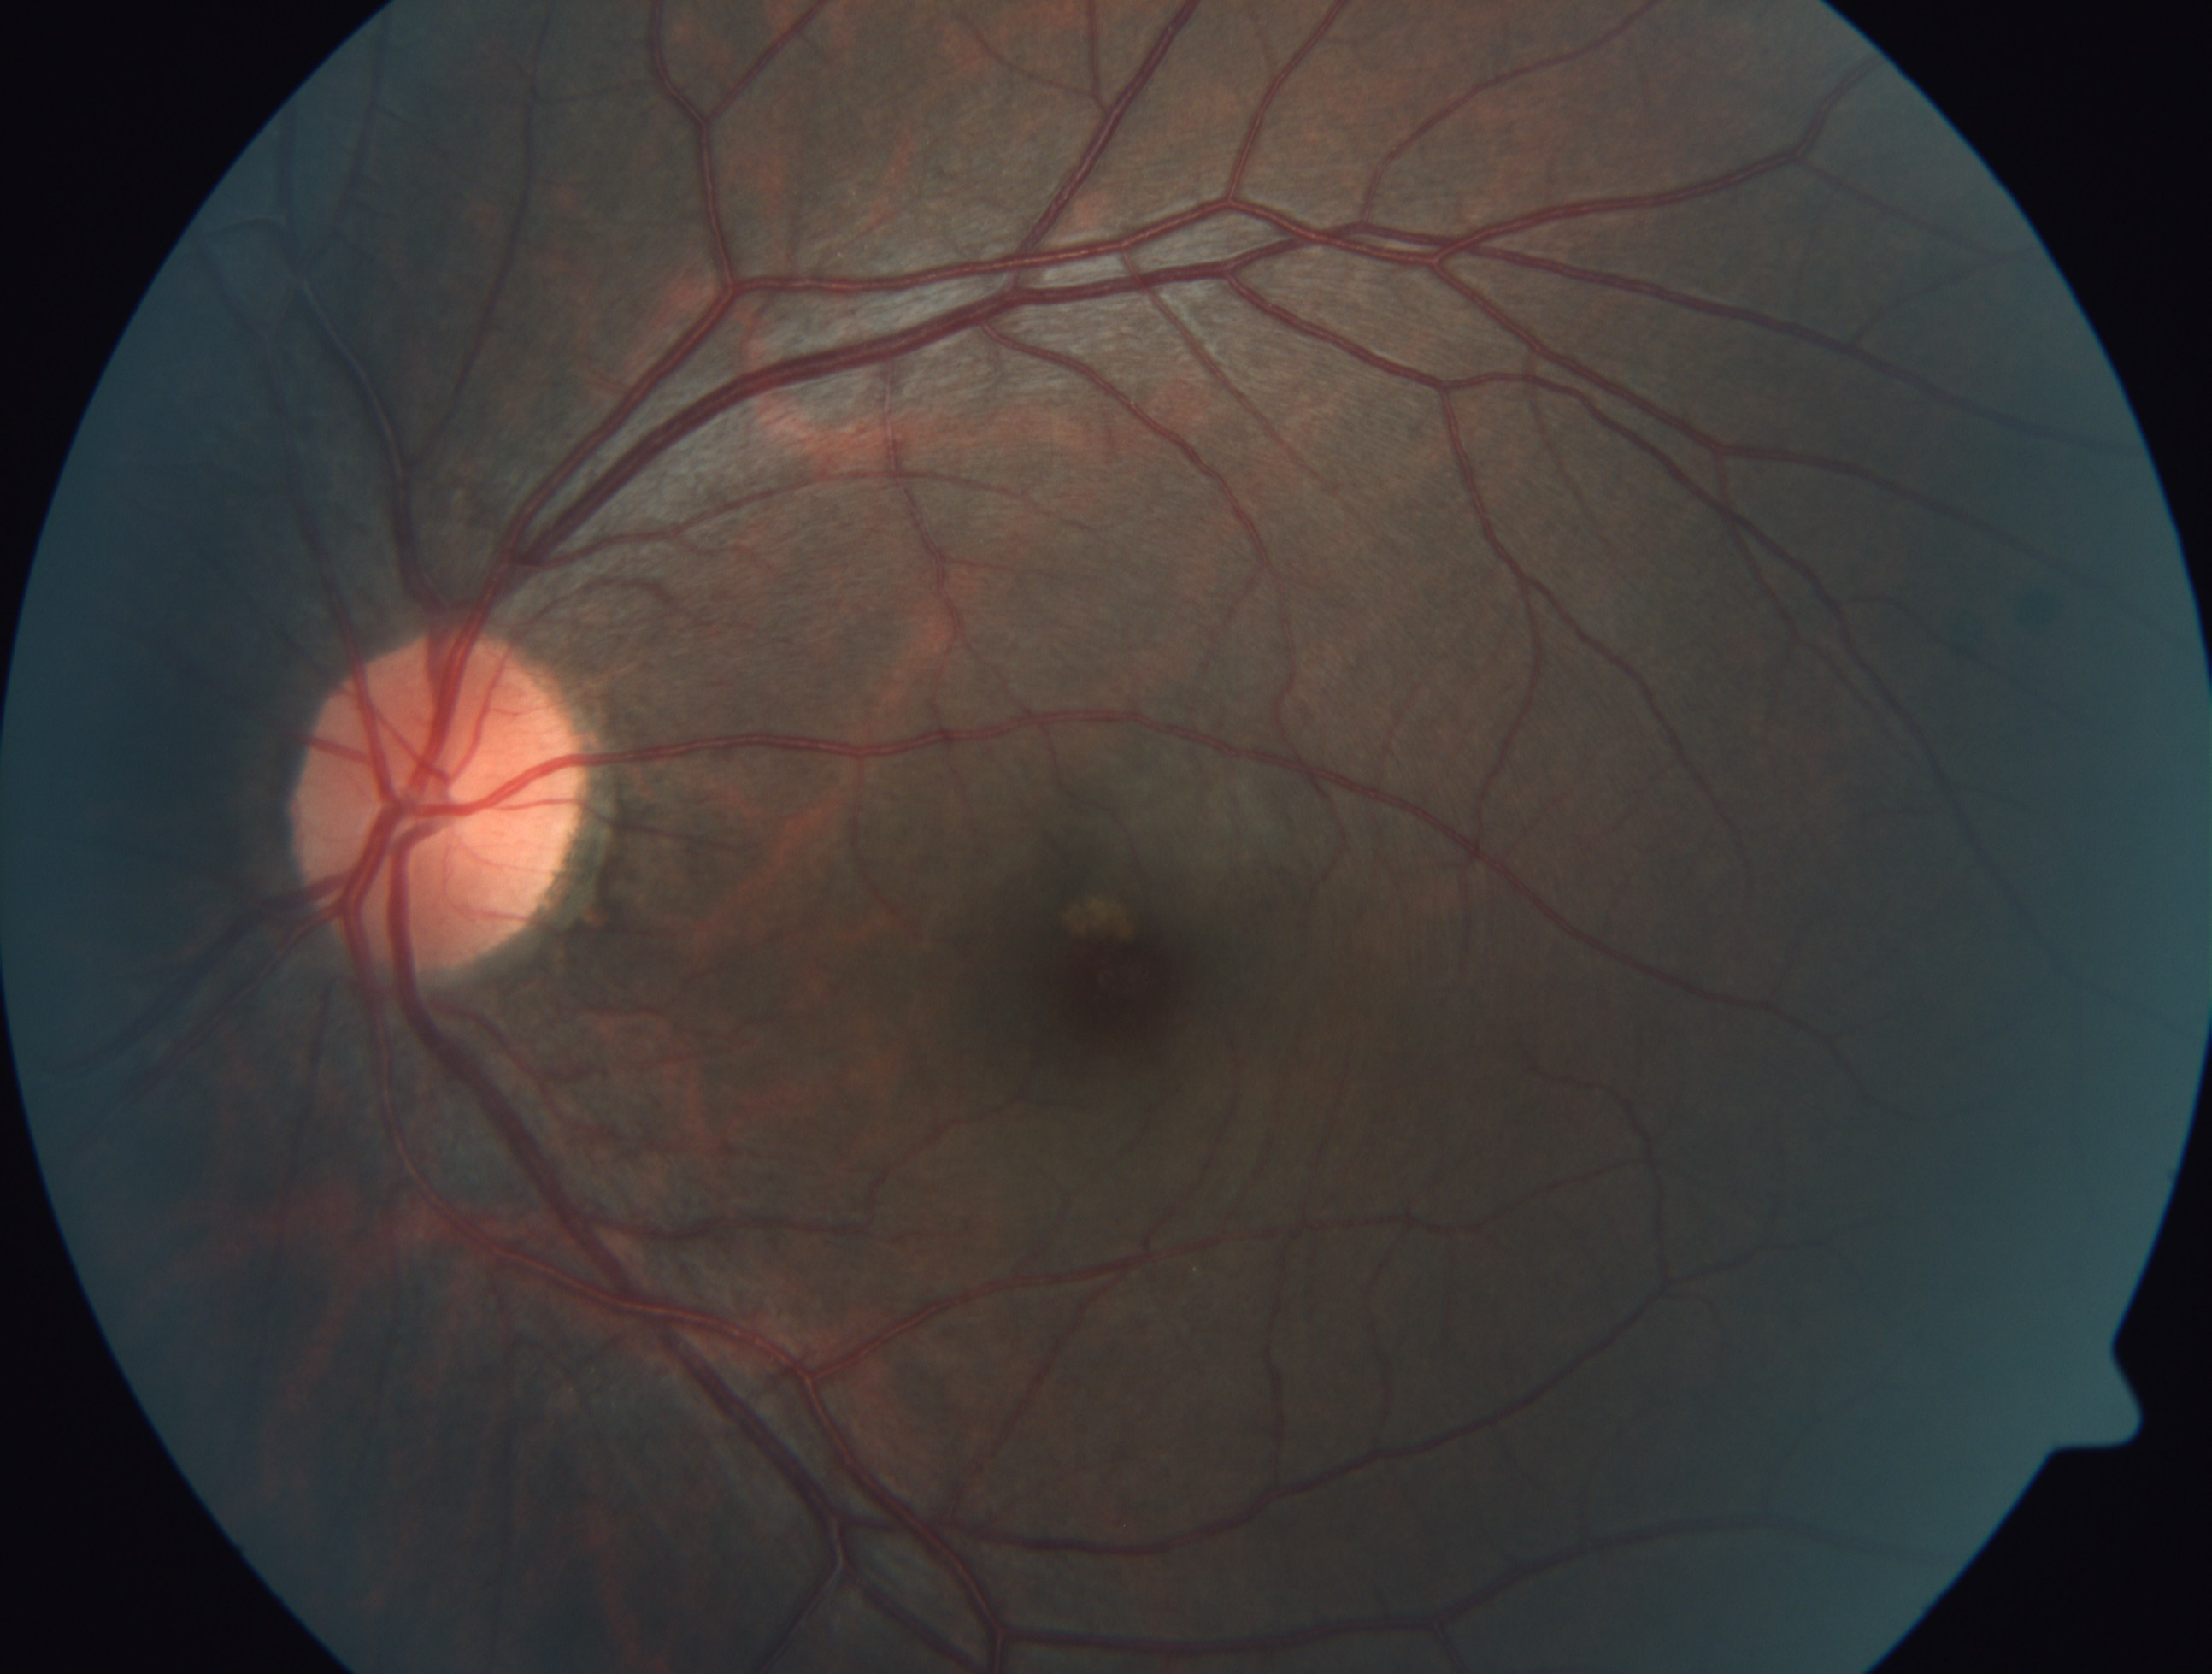

In [46]:
with Image.open(r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0135_AMLS2\AMLS_II_assignment22_23\train_images\0f364b7d4384.png') as im:
    
# Print the shape of the numpy array (height, width, channels)
    print("Image shape:", np.array(im).shape)
    display(im)


In [47]:
path = r'C:\\Users\\salda\\Documents\\Tanulas\\4th_year\\ELEC0135_AMLS2\\AMLS_II_assignment22_23\\train_images'
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'\\'+img)
        
# Creating a list
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)
        
print(f'Images:  {len(img_sizes)}')
print(f'Rejects: {len(rejected)}')

Images:  3662
Rejects: 0


In [48]:
# Converting list to a DataFrame
df = pd.DataFrame(img_sizes)

# Running summary statistics on image widths
df[0].describe()

count    3662.000000
mean     2015.176679
std       884.301940
min       474.000000
25%      1050.000000
50%      2144.000000
75%      2588.000000
max      4288.000000
Name: 0, dtype: float64

In [49]:
# Running summary statistics on image heights
df[1].describe()

count    3662.000000
mean     1526.830147
std       542.663120
min       358.000000
25%      1050.000000
50%      1536.000000
75%      1958.000000
max      2848.000000
Name: 1, dtype: float64

## Image sizes do not match up

torch.Size([3, 1958, 2588])


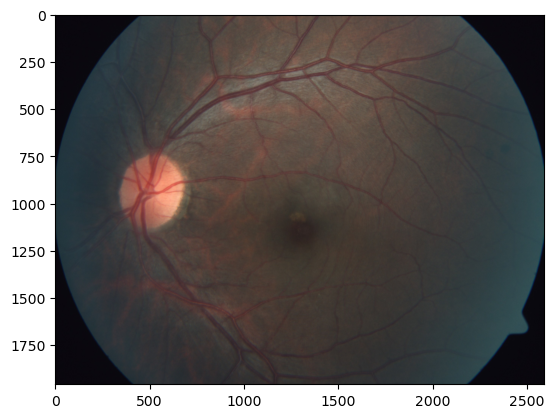

In [50]:
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])
im_t = tensor_transform(im)
print(im_t.shape)
plt.imshow(np.transpose(im_t.numpy(), (1, 2, 0)));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


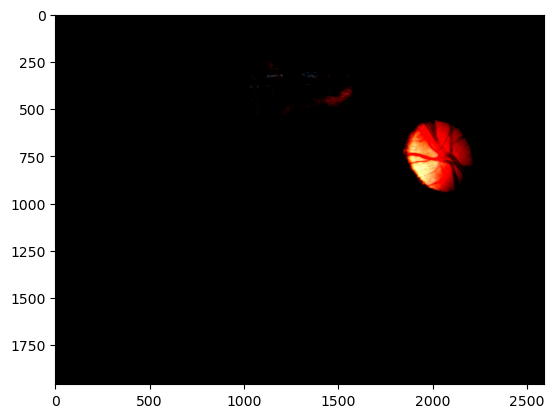

In [51]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomRotation(30, fill=0), # Filling rotated areas with white
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
im_t = transform(im)
plt.imshow(np.transpose(im_t.numpy(), (1, 2, 0)));

Imagenet normalization seems to be a bad approach for this task.

# Data labels

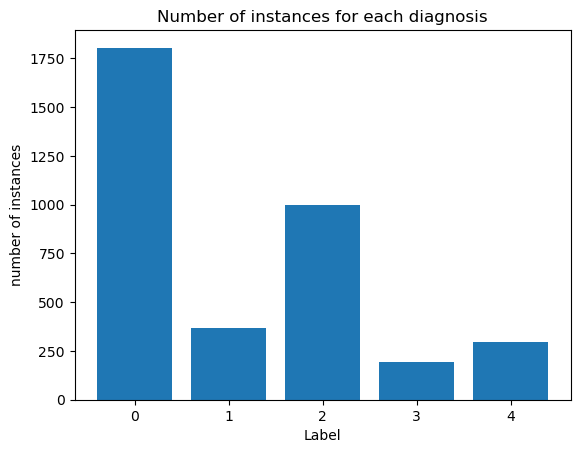

In [52]:
label_file = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0135_AMLS2\AMLS_II_assignment22_23\train.csv'
eyelabels= pd.read_csv(label_file, usecols=[1], skiprows = 1, names=['diagnosis'])['diagnosis'].tolist()

label_counts = {}

for label in eyelabels:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Generate frequency plot
sorted_label_counts = sorted(label_counts.items(), key=lambda x: x[0])
labels, frequencies = zip(*sorted_label_counts)
x_pos = range(len(labels))

plt.bar(x_pos, frequencies, align='center')
plt.xlabel('Label')
plt.ylabel('number of instances')
plt.title('Number of instances for each diagnosis')
plt.xticks(x_pos, labels)
plt.show()

Dataset is unbalanced


# Image prep

In [53]:
from torch.utils.data import Dataset
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, root_dir, label_file, transform):
        self.root_dir = root_dir
        self.label_file = label_file
        self.transform = transform

        # Read the labels from the csv file
        self.labels = pd.read_csv(label_file, usecols=[1], skiprows = 1, names=['diagnosis'])['diagnosis'].tolist()

        # Get the list of image files in ascending order (according to hexadecimal image file name)
        self.image_files = []
        for root, dirs, files in os.walk(root_dir):
            # Sort the files based on hexadecimal image file names
            files = sorted(files, key=lambda x: int(x.split('.')[0], 16))
            self.image_files.extend([os.path.join(root, file) for file in files])
    


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and apply the transformation
        image = Image.open(self.image_files[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Convert the label to a tensor
        label = torch.tensor(self.labels[idx])
        
        return image, label

# Define the root directory of the dataset and the label file
root_dir = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0135_AMLS2\AMLS_II_assignment22_23\train_images'
label_file = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0135_AMLS2\AMLS_II_assignment22_23\train.csv'

data = MyDataset(root_dir, label_file, transform=tensor_transform)



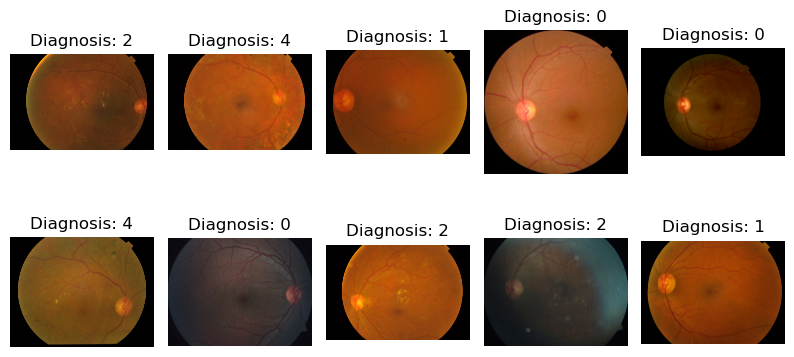

In [54]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(10, 6))

# Loop through the first 10 elements of the dataset
for i in range(10):
    # Access the image and label at index i
    image, label = data[i]
    
    # Convert the image to a PIL Image
    image = to_pil_image(image)
    
    # Get the row and column index for the subplot
    row_idx = i // 5
    col_idx = i % 5
    
    # Display the image with the label as the title on the corresponding subplot
    axes[row_idx][col_idx].imshow(image)
    axes[row_idx][col_idx].set_title(f"Diagnosis: {label.item()}")
    axes[row_idx][col_idx].axis('off')

# Adjust the layout and display the figure
plt.subplots_adjust(wspace=0.1, hspace=-0.3)
plt.show()

Images match the diagnosis

# Cropping images to get rid of unuseful information

<class 'numpy.ndarray'>
(256, 256, 3)


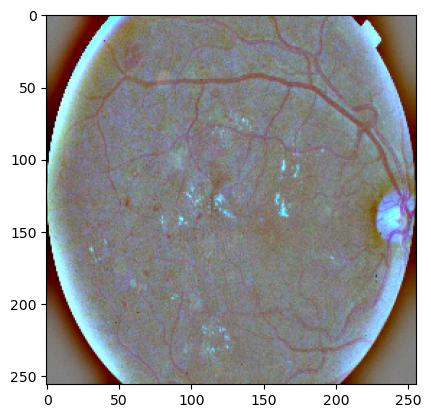

In [55]:

image, label = data[0]
image = image.numpy()
image = np.transpose(image, (1, 2, 0))
gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray_img = np.round(gray_img * 255).astype(np.uint8)
mask = gray_img>7

img1=image[:,:,0][np.ix_(mask.any(1),mask.any(0))]
img2=image[:,:,1][np.ix_(mask.any(1),mask.any(0))]
img3=image[:,:,2][np.ix_(mask.any(1),mask.any(0))]
image = np.stack([img1,img2,img3],axis=-1)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
image = np.round(image * 255).astype(np.uint8)
image = cv2.addWeighted(image, 4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)

print(type(image))
print(image.shape)

plt.imshow(image)

In [56]:
import cv2

def crop_image_from_gray(img,tol):
    # Convert to numpy array for cv2
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_img = np.round(gray_img * 255).astype(np.uint8)
    mask = gray_img>tol
    
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0): 
        print("Image is too dark. We would crop out everything.")
        return img # return original image
    else:
        img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
        img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
        img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
        
        img = np.stack([img1,img2,img3],axis=-1)

    return img

In [57]:
def highlighting(image, sigmaX):
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = np.round(image * 255).astype(np.uint8)
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

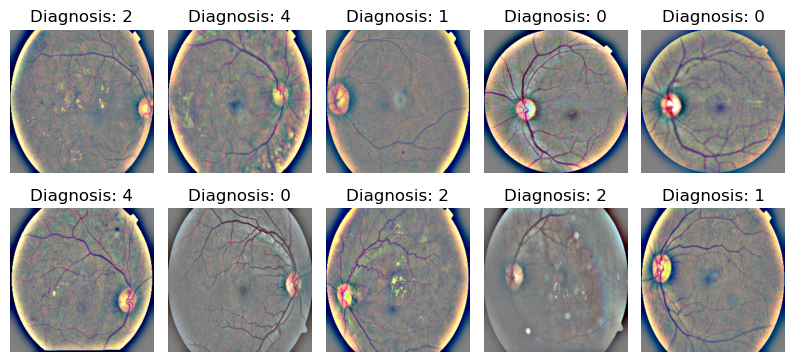

In [58]:
# Create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(10, 6))

# Loop through the first 10 elements of the dataset
for i in range(10):
    # Access the image and label at index i
    image, label = data[i]

    # Crop and highlight images
    image = crop_image_from_gray(image,5)
    image = highlighting(image, 10)

    # Get the row and column index for the subplot
    row_idx = i // 5
    col_idx = i % 5
    
    # Display the image with the label as the title on the corresponding subplot
    axes[row_idx][col_idx].imshow(image)
    axes[row_idx][col_idx].set_title(f"Diagnosis: {label.item()}")
    axes[row_idx][col_idx].axis('off')

# Adjust the layout and display the figure
plt.subplots_adjust(wspace=0.1, hspace=-0.37)
plt.show()

Training images available: 2197
Testing images available:  732
Testing images available:  733
